In [5]:
import cv2
import numpy as np
import os

import matplotlib.pyplot as plt
import glob
import pandas as pd
import json
from scipy.optimize import least_squares
import math
import random
from misc.utils import *
from misc.ReadCameraModel import ReadCameraModel
from misc.UndistortImage import UndistortImage
from misc.FundamentalMatrix import FundamentalMatrix, cv2_FundamentalMatrix, EssentialMatrix
from misc.fileutils import *
from misc.PoseEstimation import * 

# Unit Test:  Pose Estimation

In [3]:
def recoverPose(pts1_, pts2_, E, optimize = False):
    
    """
    given a set of points and essential matrix, estimate pose
    """
    
    if (pts1_.shape[1] == 2) or (pts1_.shape[1] == 2): 
        pts1_,pts2_ = homo(pts1_),homo(pts2_)

    ### estimate all 4 mathematically possible poses###
    poses = estimatePoses(E) 
    max_positiveZ, correctPose = 0, None
    
    ## choose the only physically possible pose
    for pose in poses:        
        ## get 3D points ##
        pts3D = LinearTriangulation(pts1_, pts2_, pose)  
        
        # if optimize:
            ## perform non linear optimization
            
        ### get n positive depths of the pose###
        n_positiveZ = ChieralityCheck(pts3D, pose)
        ## choose the pose with most positive depth results.
        if n_positiveZ >= max_positiveZ :
            max_positiveZ = n_positiveZ
            correctPose = pose

    return correctPose

def LinearTriangulation(pts1, pts2, pose):
    
    """
    To perform linear triangulation,
    np.cross(x,P)X = 0 and np.cross(x',P')X = 0 relationships need to be satisfied.
    X : 3D point 
    x : 2d image point 
    P : projection matrix

    Reference: http://www.cs.cmu.edu/~16385/s17/Slides/11.4_Triangulation.pdf
    """        
    # Following the general parameterization of dependant images, 
    #Pose1 is a  reference frame, Pose2 is our estimated pose
    Pose1, Pose2 = np.eye(3,4), pose
    pts3D = []
    for x1, x2 in zip(pts1, pts2):    
        x1P1 = cross_1Dx4D(x1,Pose1)
        x2P2 = cross_1Dx4D(x2,Pose2)
        A = np.vstack((x1P1, x2P2))

        _,_,Vt = np.linalg.svd(A)
        X = Vt[-1]
        X = X/X[-1]
        pts3D.append(X[:3]) 

    return np.array(pts3D)

def ChieralityCheck(pts3D, pose):
    r3 = pose[:,2]
    c = pose[:,2]
#     r3 = pose[2, :3]
#     c = pose[:, 3]
    n_positiveZ = 0
    for X in pts3D:
        # cheirality condition
        if (r3 @ (X - c)) > 0:
            n_positiveZ += 1
    return n_positiveZ

def homo(pts):
    return np.column_stack((pts, np.ones(len(pts)).reshape(-1,1)))

def cross_1Dx4D(x,P):
    """
    to find cross product between a 1D vector and 4D projection matrix
    """
    x_3x3 = np.array([[0, -x[2], x[1]],
                      [x[2], 0, -x[0]],
                      [-x[1], x[0], 0]])
    return x_3x3 @ P


def estimatePoses(E):
    U, _, Vt = np.linalg.svd(E, full_matrices=True)
    W = np.array([
        [0, -1, 0],
        [1, 0, 0],
        [0, 0, 1]])

    R12 = U @ W @ Vt
    R34 = U @ W.T @ Vt
    C = U[:, 2]
    
    poses = np.array([np.column_stack((R12, C)),
                      np.column_stack((R12, -C)),
                      np.column_stack((R34, C)),
                      np.column_stack((R34, -C))])

#     poses = signcheck(poses)
    poses = np.array([adjust_sign(pose) for pose in poses])
    return np.array(poses)

def adjust_sign(pose):
    COL4 = 3
    pose = -pose if np.linalg.det(pose[:, :COL4]) < 0 else pose
    return pose

def signcheck(poses):
    poses_ = []
    for pose  in poses:
        r = pose[:, :3]
        if np.linalg.det(r) <0:
            poses_.append(-pose)
        else:
            poses_.append(pose)
    return poses_

In [4]:
def get_possible_camera_poses(essential_mat):
    U, _, VT = np.linalg.svd(essential_mat, full_matrices=True)
    W = np.array([
        [0, -1, 0],
        [1, 0, 0],
        [0, 0, 1]
    ])
    COL3 = 2
    #P′ = [UWVT | +u3] or [UWVT | −u3] or [UWTVT | +u3] or [UWTVT | −u3].
    poses = np.array([
        np.column_stack( (U @ W @ VT, U[:, COL3]) ),
        np.column_stack( (U @ W @ VT, -U[:, COL3]) ),
        np.column_stack( (U @ W.T @ VT, U[:, COL3]) ),
        np.column_stack( (U @ W.T @ VT, -U[:, COL3]) )
    ])

    poses = np.array([
        adjust_sign(pose) for pose in poses
    ])
    
    return poses


def adjust_sign(pose):
    COL4 = 3
    pose = -pose if np.linalg.det(pose[:, :COL4]) < 0 else pose
    return pose

def get_linear_triangulated_points(pose, point_list1, point_list2):
    P = np.eye(3,4)
    P_dash = pose
    points_3D = []
    num_points = len(point_list1)
    for i in range(num_points):
        point1 = point_list1[i]
        point2 = point_list2[i]
        '''
        A = np.array([
            (point1[Y] * P[ROW3]) - P[ROW2],
            P[ROW1] - (point1[X]*P[ROW3]),
            (point2[Y] * P_dash[ROW3]) - P_dash[ROW2],
            P_dash[ROW1] - (point2[X] * P_dash[ROW3])
        ])
        '''
        X, Y, Z = 0, 1, 2
        point1_cross = np.array([
            [0, -point1[Z], point1[Y]],
            [point1[Z], 0, -point1[X]],
            [-point1[Y], point1[X], 0]
        ])

        point2_cross = np.array([
            [0, -point2[Z], point2[Y]],
            [point2[Z], 0, -point2[X]],
            [-point2[Y], point2[X], 0]
        ])

        point1_cross_P = point1_cross @ P
        point2_cross_P_dash = point2_cross @ P_dash

        A = np.vstack((point1_cross_P, point2_cross_P_dash))

        _, _, VT = np.linalg.svd(A)
        solution = VT.T[:, -1]
        solution /= solution[-1]

        points_3D.append([solution[X], solution[Y], solution[Z]])
        #yield [solution[X], solution[Y], solution[Z]] 
          
    return points_3D

def ccheck(pts3D_ref, pose_ref):
    num_positive_depths = 0
    rot3 = pose_ref[2, :3]
    C = pose_ref[:, 3]
    for point in pts3D_ref:
        # cheirality condition
        if (rot3 @ (point - C)) > 0:
            num_positive_depths += 1
    return num_positive_depths

In [24]:
i =10
BasePath = '../Data/'
K, LUT = CameraMatrix(BasePath)
E_record = loadDict(name = 'Essential_1')
print(len(E_record))

pts1_, pts2_ = loadSIFTmatches(i, siftFilepath = './data/sift_inliers/')
if (pts1_.shape[1] == 2) or (pts1_.shape[1] == 2): 
    pts1_,pts2_ = homo(pts1_),homo(pts2_)
E = np.array(E_record[str(i)])


3852


In [14]:
# Mat P0 = Mat::eye(3, 4, R1.type());
# Mat P1(3, 4, R1.type()), P2(3, 4, R1.type()), P3(3, 4, R1.type()), P4(3, 4, R1.type());

# P1(Range::all(), Range(0, 3)) = R1 * 1.0; P1.col(3) = t * 1.0;
# P2(Range::all(), Range(0, 3)) = R2 * 1.0; P2.col(3) = t * 1.0;
# P3(Range::all(), Range(0, 3)) = R1 * 1.0; P3.col(3) = -t * 1.0;
# P4(Range::all(), Range(0, 3)) = R2 * 1.0; P4.col(3) = -t * 1.0;


array([[  31.61531067,  464.15618896],
       [  32.98831558,  285.25265503],
       [  38.25412369,  457.60552979],
       ...,
       [1259.60546875,  271.20895386],
       [1261.72692871,  339.8770752 ],
       [1270.11022949,  613.7666626 ]])

In [31]:
P0 = np.eye(3,4)

R1, R2, t = decomposeEssentialMat(E)



numpy.float64

In [39]:
BasePath = '../Data/'
K, LUT = CameraMatrix(BasePath)
E_record = loadDict(name = 'EssentialMatrix')
print(len(E_record))


for i in range(len(E_record)):
    pts1_, pts2_ = loadSIFTmatches(i, siftFilepath = './data/sift_inliers/')
    E = np.array(E_record[str(i)])
    retval, R, t, mask = cv2.recoverPose(E, pts1_, pts2_, K) # inbuilt pose estimation function
    correctPose_ref = np.column_stack((R,t))    
#     print('Point len: ',len(pts1_))
    if (pts1_.shape[1] == 2) or (pts1_.shape[1] == 2):
        pts1_, pts2_ = homo(pts2_),homo(pts2_)
    poses = estimatePoses(E)
    max_positiveZ, correctPose= 0, None
    ## choose the only physically possible pose
    print_ = (-1,1)
    for p,pose in enumerate(poses):
        counter = 0
        ## get 3D points ##
        pts3D = LinearTriangulation(pts1_, pts2_, pose)
        n_positiveZ = ChieralityCheck(pts3D, pose)
            
        if (n_positiveZ > max_positiveZ) :
            max_positiveZ = n_positiveZ
            correctPose = pose
            best_i = p
        elif (n_positiveZ == max_positiveZ):
            print_ = (best_i, p)
            
    if np.linalg.norm(correctPose- correctPose_ref) > 1.0:
        print('duplicates ', print_)
    
    

3852
duplicates  (-1, 1)
duplicates  (2, 0)
duplicates  (-1, 1)
duplicates  (2, 0)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (0, 0)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (2, 1)
duplicates  (-1, 1)
duplicates  (2, 0)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (3, 0)
duplicates  (-1, 1)
duplicates  (2, 0)
duplicates  (3, 0)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (0, 0)
duplicates  (-1, 1)
duplicates  (0, 0)
duplicates  (-1, 1)
duplicates  (0, 0)
duplicates  (3, 0)
duplicates  (3, 0)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (2, 0)
duplicates  (3, 0)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates  (-1, 1)
duplicates

KeyboardInterrupt: 

0.0

In [ ]:

"""
given a set of points and essential matrix, estimate pose
"""

if (pts1_.shape[1] == 2) or (pts1_.shape[1] == 2): 
    pts1_,pts2_ = homo(pts1_),homo(pts2_)

### estimate all 4 mathematically possible poses###
poses = estimatePoses(E) 
max_positiveZ, correctPose = 0, None

## choose the only physically possible pose
for pose in poses:        
    ## get 3D points ##
    pts3D = LinearTriangulation(pts1_, pts2_, pose)  

    # if optimize:
        ## perform non linear optimization

    ### get n positive depths of the pose###
    n_positiveZ = ChieralityCheck(pts3D, pose)
    ## choose the pose with most positive depth results.
    if n_positiveZ >= max_positiveZ :
        max_positiveZ = n_positiveZ
        correctPose = pose

# Full pipeline

In [14]:
frameSavepath = './Outputs/'
foldercheck(frameSavepath)

BasePath = '../Data/'

load_sift =False
pts1_, pts2_ = None, None

prev_pose = np.eye(4)
K, LUT = CameraMatrix(BasePath)
impaths =  ImagePaths(BasePath)

pose_record = loadPoses() # empty initially

trajectory_points = []
for i in range(len(impaths)):
    
    im1, im2 = preprocess(impaths[20:],LUT, i)

    if load_sift == True:
        pts1_, pts2_ = loadSIFTmatches(i, siftFilepath = './data/sift/')

    if pts1_ is None or pts2_ is None or load_sift == False:
        pts1,pts2 = SIFTpoints(im1, im2)
        
        saveSIFTmatches(i, pts1, pts2)
        print(len(pts1))

    data = (pts1,pts2)
    F,inlier_mask = FundamentalMatrix(data ,s = 8, thresh = 0.0001,n_iterations = 75)
    pts1_ = pts1[inlier_mask==1]
    pts2_ = pts2[inlier_mask==1]    

    E = EssentialMatrix(K, F)
    estimated_pose = recoverPose(pts1_, pts2_, E, optimize = False)
    estimated_pose = np.vstack((estimated_pose, np.array([0,0,0,1])))
    pose_record[str(i)] =  estimated_pose
    
    current_pose = prev_pose @ estimated_pose
    prev_pose = current_pose

    x_coordinate = current_pose[0, -1]
    z_coordinate = current_pose[2, -1]
    
    plt.scatter(x_coordinate, -z_coordinate, color='r')
    trajectory_points.append(np.array([x_coordinate, z_coordinate]))
    print('\nframe_count', i)
    plt.savefig(frameSavepath+str(i)+'.png', bbox_inches='tight')

savePoses(pose_record)

np.save('trajectory_points.npy', np.array(trajectory_points))


2016




frame_count 50


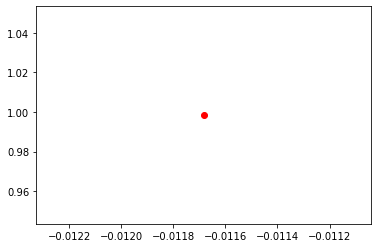

In [17]:

# print('\n\nTime taken: ', (time.clock() - start))


# plt.pause(0.00001)

# 

# frm = cv2.resize(frame1, (0,0), fx=0.5, fy=0.5)
# cv2.imshow('Frame', frm)

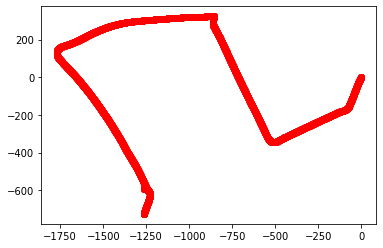

In [36]:
plt.scatter(-data[:,1],data[:,0],  color='r')

In [28]:
data = np.load('data_pts.npy')

# Unit test : Fundamental Matrix

In [3]:
def fundamentalMatrix(edge1, edge2): 
    A_x = np.empty((8, 9))

    for i in range(0, len(edge1)):
        x_1 = edge1[i][0]
        y_1 = edge1[i][1]
        x_2 = edge2[i][0]
        y_2 = edge2[i][1]
        A_x[i] = np.array([x_1*x_2, x_2*y_1, x_2, y_2*x_1, y_2*y_1, y_2, x_1, y_1, 1])

    u, s, v = np.linalg.svd(A_x, full_matrices=True)  
    f = v[-1].reshape(3,3)
    u1,s1,v1 = np.linalg.svd(f) 
    s2 = np.array([[s1[0], 0, 0], [0, s1[1], 0], [0, 0, 0]])
    F = u1 @ s2 @ v1    
    return F  

def FmatrixCond(x1,x2,F): 
    x11=np.array([x1[0],x1[1],1]).T
    x22=np.array([x2[0],x2[1],1])
    return abs(np.squeeze(np.matmul((np.matmul(x22,F)),x11)))

def FunMat_sanket(features1,features2):
    Total_inliers = 0
    FinalFundamentalMatrix = np.zeros((3,3))
    inlier1 = []
    inlier2 = []
    for i in range(0, 50):
        count = 0
        Extracted_points = []
        Frame1_features = []
        Frame2_features = []
        TemporaryFeatures_1 = []
        TemporaryFeatures_2 = []
        
        while(True):
            num = random.randint(0, len(features1)-1)
            if num not in Extracted_points:
                Extracted_points.append(num)
            if len(Extracted_points) == 8:
                break
                
        for point in Extracted_points:
            Frame1_features.append([features1[point][0], features1[point][1]])
            Frame2_features.append([features2[point][0], features2[point][1]])
    
        FundMatrix = fundamentalMatrix(Frame1_features, Frame2_features)

        for number in range(0, len(features1)):
            if FmatrixCond(features1[number], features2[number], FundMatrix) < 0.01:
                count = count + 1
                TemporaryFeatures_1.append(features1[number])
                TemporaryFeatures_2.append(features2[number])

        if count > Total_inliers:
            Total_inliers = count
            FinalFundamentalMatrix = FundMatrix
            inlier1 = TemporaryFeatures_1
            inlier2 = TemporaryFeatures_2
    
    return FinalFundamentalMatrix, np.array(inlier1),np.array(inlier2)



[[-7.30335499e-10 -9.22930895e-06  3.92862903e-03]
 [ 9.23920929e-06  1.53073621e-08 -6.17250890e-03]
 [-3.91694877e-03  6.14320360e-03 -5.82042936e-04]] 1772.0 (1772, 2) (1772, 2)
[[-1.57939245e-05  2.33422061e-02 -1.08215292e+01]
 [-2.33594576e-02 -5.15328515e-05  1.62767783e+01]
 [ 1.08136869e+01 -1.62147817e+01  1.00000000e+00]] 1835 (1835, 2) (1835, 2)
[[ 4.40157901e-07  6.82638558e-04 -3.12419927e-01]
 [-6.82084444e-04  1.60048262e-08  4.39372203e-01]
 [ 3.10594838e-01 -4.38982352e-01  6.48205420e-01]] (593, 2) (593, 2)


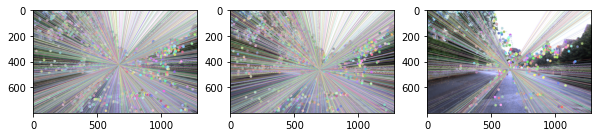

In [121]:
data = (pts1,pts2)
F,inlier_mask = FundamentalMatrix(data ,s = 8, thresh = 0.0001,n_iterations = 75)
pts1_ = pts1[inlier_mask==1]
pts2_ = pts2[inlier_mask==1]
print(F, inlier_mask.sum(), pts1_.shape, pts2_.shape)
E = EssentialMatrix(K, F)

F1, mask1 = cv2_FundamentalMatrix(pts1,pts2, a = 1, b= 0.90)
pts1_1 = pts1[mask1==1]
pts2_1 = pts2[mask1==1]
print(F1, mask1.sum(), pts1_1.shape, pts2_1.shape)
E1 = EssentialMatrix(K, F1)
F2,pts1_2, pts2_2 = FunMat_sanket(pts1,pts2)
print(F2, pts1_2.shape, pts2_2.shape)
E2 = EssentialMatrix(K, F2)

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F1)
lines2 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F2)

im1_print2,_ = drawlines(im1,im2,lines2,pts1_2,pts2_2)
im1_print1,_ = drawlines(im1,im2,lines1,pts1_1,pts2_1)
im1_print,_ = drawlines(im1,im2,lines,pts1_,pts2_)

ax, plts = plt.subplots(1,3, figsize = (10,10))
plts[0].imshow(im1_print)
plts[1].imshow(im1_print1)
plts[2].imshow(im1_print2)

# Half done Pipeline

In [54]:
i=1001


# pts1,pts2 = findFeatures(im1, im2, ld = 0.85)
print(pts1.shape, pts2.shape)
if len(pts1) == 0 or len(pts2) == 0 :
    prev_pts1, prev_pts2 = pts1, pts2

(1472, 2) (1472, 2)


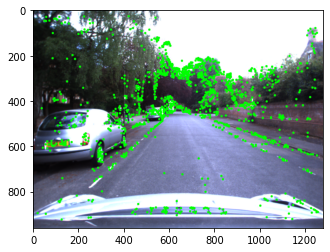

In [55]:
im1_print, im2_print = drawPoints(im1, im2, pts1, pts2)
plt.imshow(im1_print)

In [37]:
E = EssentialMatrix(K, F)
ret, R, t, _ = cv2.recoverPose(E, pts1_, pts2_, K) # inbuilt pose estimation function

In [40]:
np.column_stack((R, t))

array([[ 0.89397906, -0.39156904, -0.21788786,  0.02733948],
       [-0.43864987, -0.86407017, -0.24691909, -0.00448745],
       [-0.09158453,  0.31631698, -0.94422235,  0.99961613]])